## Important Information About The Data & Assumptions

I collected this data using an automated Python script that pulled the data from the Youtube Trending page using the Youtube Data API. This script ran 2 times daily at the same time. A flaw with this approach is that because because it collected at the exact same times everyday, the collection process was not truly random. Not all videos had an equal chance of being collected. For example, a video that appeared on the trending page from only 3:00-5:00 would never have a chance at being collected, because the script captures the whole trending page at 11:00 AM and PM. In the future, I would find some way to get real-time data so all videos are collected constantly. However, this might be computationally expensive, so I would probably find a way to have the script run 2 times daily, but at random times.


## Importing Libraries & Data

In [2]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.express as px
import statsmodels.api as sm
from scipy.stats import kruskal
import pingouin as pg

In [3]:
#import data
df = pd.read_csv('youtube_data.csv')
categories = pd.read_csv('youtube_categories.csv')

In [4]:
#mapping category_id to category name
df = df.merge(categories, on = 'category_id', how = 'left')
df = df.drop_duplicates(subset = 'video_id')

## Data Preprocessing

Consider the formula:

$$Engagement = \frac{{\text{{Likes}} + \text{{Comments}}}}{{\text{{Views}}}}$$

This engagement metric I used is an attempt to quantify user engagement with a Youtube video. It takes into account the number of likes and comments relative to the total number of views. This allows for a fair comparison between videos with varying view counts. An assumption being made is that highly engaging videos tend to accumulate a larger number of likes and comments in relation to the number of views they receive.

An advantage to using this metric over just views, likes, or comments is that it allows us to identify videos that audiences interact with strongly, even if that video hasn't reached a broader audience. In contrast, a video with a high number of views, but a low amount of likes and comments relative to the high view count would be deemed less engaging. 

I came up with this metric on my own, and there are several limitatons to be aware of
1. Likes and Comments are weighed equally. It is possible that comments should be weighed more since it takes more effort from the user's end to comment their opinion on the video compared to simply pressing the like button. The reason why likes and comments are weighed equally in this case is because their is no way to effectively measure what the quality of a comment is without using some natural language processing techniques of some sort.
2. Comments are weighted only by the number of comments. The quality of the comment is not taken into account.
3. This metric is susceptible to like and comment bots, which would artificially inflate the engagement of some videos.

One metric I wanted to add to the engagement equation was viewer retention rate of the video, but that data isn't publicly available. Another possible metric taken directly from [Youtube's support page](https://support.google.com/youtube/answer/2991785?hl=en#:~:text=YouTube%20engagement%20metrics%20) is counting the views of the ads in a Youtube video (if the video has adds). The logic behind this is that if a viewer watches or skips an ad, they are engaging with the video. Again, this was not factored into the equation above because the data was not publicly available.

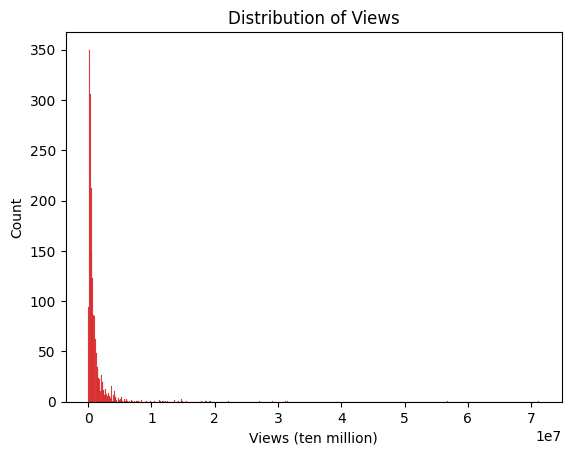

In [39]:
sns.histplot(df['view_count'], color = '#FF0000');
plt.xlabel('Views (ten million)');
plt.title('Distribution of Views');

In [34]:
df['view_count'].describe()

count    1.905000e+03
mean     1.280438e+06
std      3.150340e+06
min      1.710500e+04
25%      2.996860e+05
50%      5.494390e+05
75%      1.136800e+06
max      7.125609e+07
Name: view_count, dtype: float64

A possible concern with this definition of an engagement metric is that it doesn't account for the difficulty of achieving the engagement elvel relative to the number of views. Consider the example below:

For Video A: Engagement = (5 + 5) / 10 = 1
For Video B: Engagement = (4,000 + 4,000) / 10,000 = 0.8
According to this engagement metric, Video A appears to have a higher engagement level (1) compared to Video B (0.8), despite having significantly fewer likes and comments. This raises a concern because the engagement score of Video A seems disproportionately high compared to its small number of views.

The flaw in this engagement formula becomes evident when we consider the relative effort required to achieve the engagement levels for each video. Video A only needed to gather 5 likes and 5 comments, which could be achieved quite easily even by a small number of viewers. On the other hand, Video B had to gather 4,000 likes and 4,000 comments, which is a substantial effort and interaction level even for a large number of viewers.

Because as shown above, the mean and median view counts are in the millions, the problem of less viewed videos having disproportionally high engagment should not be a problem.

Here is a very quick sanity check to test the assumption that that highly engaging videos tend to accumulate a larger number of likes and comments in relation to the number of views they receive:

Text(1038.0163398692812, 0.5, 'Comments')

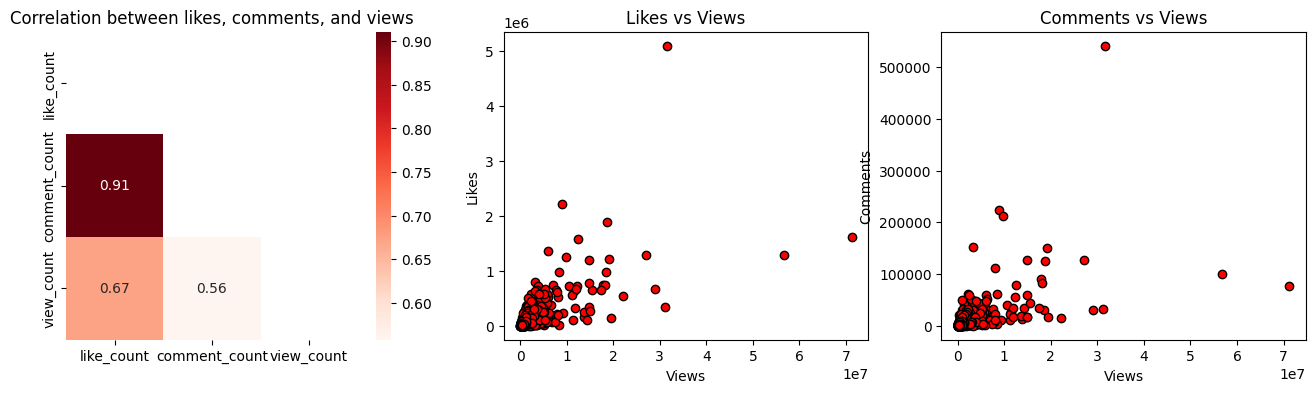

In [5]:
#figure plots
fig, ax = plt.subplots(1, 3, figsize = (16, 4))

#creating a correlation heatmap
corr = df[['like_count', 'comment_count', 'view_count']].corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot = True, cmap = 'Reds', mask = mask, ax = ax[0]);
ax[0].set_title('Correlation between likes, comments, and views');

#Likes vs Views scatterplot
ax[1].scatter(df['view_count'], df['like_count'],  color = "#FF0000", edgecolor = "black");
ax[1].set_title('Likes vs Views');
ax[1].set_xlabel('Views');
ax[1].set_ylabel('Likes')

#Comments vs Views scatterplot
ax[2].scatter(df['view_count'], df['comment_count'],  color = "#FF0000", edgecolor = "black");
ax[2].set_title('Comments vs Views');
ax[2].set_xlabel('Views');
ax[2].set_ylabel('Comments')

As shown in the correlation heatmap, comments have a moderate, positive correlation with view count. Like count and view count have a moderately strong, positive correlation. Finally like count and comment count have a strong, positive correlation. Since likes and views seem to have at least a moderate, positive correlation with views, it is reasonable to assume that comments and likes increase with respect to view count.

In [6]:
#computing engagement metric column
df['engagement'] = (df['like_count'] + df['comment_count']) / df['view_count']

In [7]:
#converting column to datetime type
df['published_at'] = pd.to_datetime(df['published_at'])

In [8]:
df.dtypes

published_at      datetime64[ns]
video_id                  object
channel_id                object
title                     object
channel_title             object
view_count                 int64
like_count                 int64
comment_count              int64
tags                      object
duration                 float64
category_id                int64
timestamp                 object
category_title            object
engagement               float64
dtype: object

In [9]:
#converting string representation of lists to lists
df['tags'] = df['tags'].apply(lambda x: eval(x))

## Measuring Video Engagment and Observing Its Trends

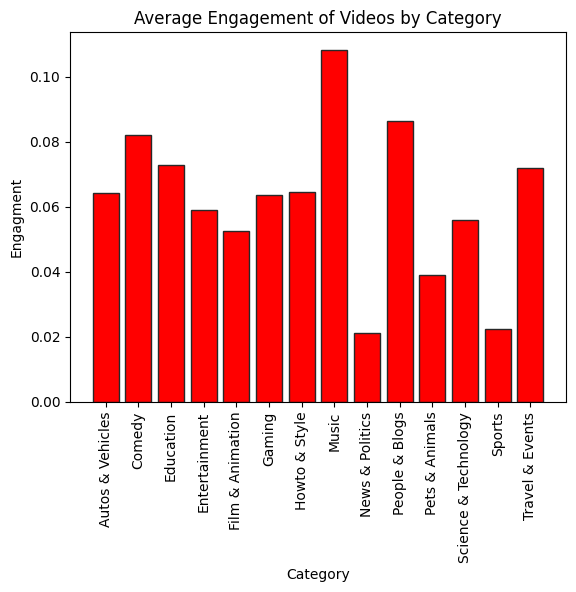

In [10]:
#Video categories with the most engagment
agg_cat = df.groupby('category_title')['engagement'].mean()
plt.bar(x = agg_cat.index, height = agg_cat, color = "#FF0000", edgecolor = '#282828');
plt.xticks(rotation=90);
plt.xlabel('Category');
plt.ylabel('Engagment');
plt.title('Average Engagement of Videos by Category');

It seems that the Music category seems to be the most engaging category according to the calculated engagement metric, while News & Politicswas the least engagement. Does that mean Youtubers who cover news and politics are not going to make videos as engaging as a music video? Well, according to this metric, yes, but context has to also be taken into account. Music videos can evoke emotions, and music videos by artists are designed to entertain and captivate viewers. This can lead to higher engagement in the form of more likes and comments. On the other hand, news & politics may naturally have less engagement, as people may only watch to get the information in the news. Additionally, the controversial topics covered in news and politics may discourage viewers from commenting and expressing their opinions. Overall, it wouldn't be completely correct to assume that a Youtuber who focuses on news and politics is going to be less engaging than a music-focused Youtuber, as engagement can naturally vary across genres.

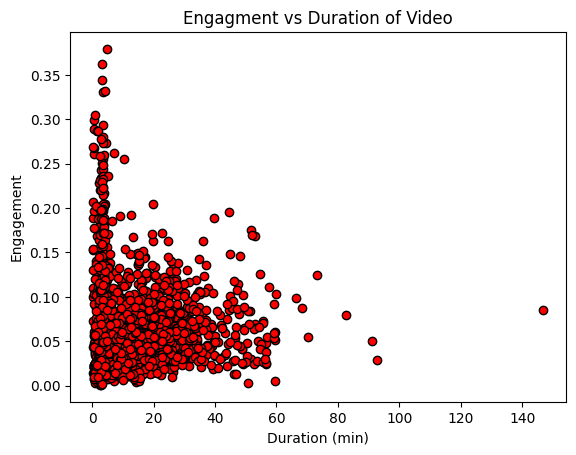

In [11]:
#Engagement vs Duration scatterplot
plt.scatter(x = df.duration, y = df.engagement, edgecolors = "black", color = "#FF0000");
plt.xlabel('Duration (min)');
plt.ylabel('Engagement');
plt.title('Engagment vs Duration of Video');

Looking at the scatterplot, it is possible that shorter videos tend to have a higher engagment on average, but a different visualization may help us make more accurate interpretations.

In [12]:
#removing outliers to bin data by duration appropriately
q1 = df.duration.quantile(0.25)
q3 = df.duration.quantile(0.75)
iqr = q3 - q1

lower_thresh = q1 - (1.5 * iqr)
upper_thresh = q3 + (1.5 * iqr)

is_not_outlier = (df['duration'] >= lower_thresh) & (df['duration'] <= upper_thresh)
df_no_outliers = df[is_not_outlier][['engagement', 'duration']].copy()

#binning data
bins = list(range(0, int(df_no_outliers['duration'].max()), 5))
df_no_outliers['duration_bin'] = pd.cut(df_no_outliers['duration'], bins)
df_no_outliers = df_no_outliers.dropna(axis = 0, how = 'any')
grouped_bins = df_no_outliers.groupby('duration_bin').mean().reset_index()

x_ticks = grouped_bins['duration_bin'].apply(lambda x : x.right)


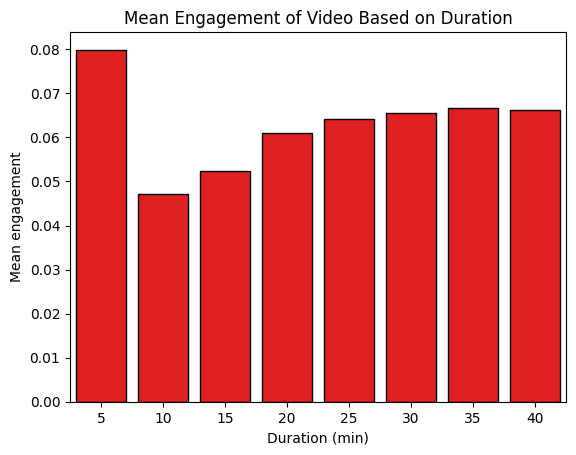

In [13]:
#barplotting average engagement based on duration of videos
sns.barplot(x = x_ticks, y = grouped_bins.engagement, edgecolor = "black", color = "#FF0000");
plt.xlabel('Duration (min)');
plt.ylabel('Mean engagement');
plt.title('Mean Engagement of Video Based on Duration');

As shown in the barplot, it seems that 0-5 minute videos tend to have the highest engagement, then engagement seems to drop from 10-15 minute videos and slowly increases as videos get longer. Let's try to do a significance test to see if short form content (0-5 minute videos) have a significantly higher engagement than other duration videos. The first test considered was an ANOVA (Analysis of Variance) test, which would helpe determine if there is a significant difference in the meanengagement across multiple duration bins. 

The ANOVA test requires the following conditions:
1. Independence of observations within each group
2. Normality
3. Homogeneity of Variances

The data was not normally distributed, so ANOVA could not be applied. Thus, I looked for non-parametric tests and found the Kruskal-Wallis test with the following conditions:
For the independence condition, here a few violations:

1. Independent samples: The Kruskal-Wallis test assumes that the samples in each group are independent of each other. Each observation should be randomly assigned to a group, and there should be no dependency or relationship between observations within and between groups.
2. Homogeneity of shapes
3. Independent ranks: The Kruskal-Wallis test is based on rank ordering the observations within each group. It assumes that the ranks assigned to the observations are independent of each other. If tied observations exist, the test adjusts for ties to maintain valid results.
4. Random sampling

Below are potential violations of independence, but for simplicity's sake, I decided to continue the test
- Videos that are released in a series, where there is sequential storytelling may violate independence.
-  Videos that appear on the trending page might receive more views, likes, and comments, which could potentially introduce dependencies within each group. The popularity of a video can influence the engagement it receives.'

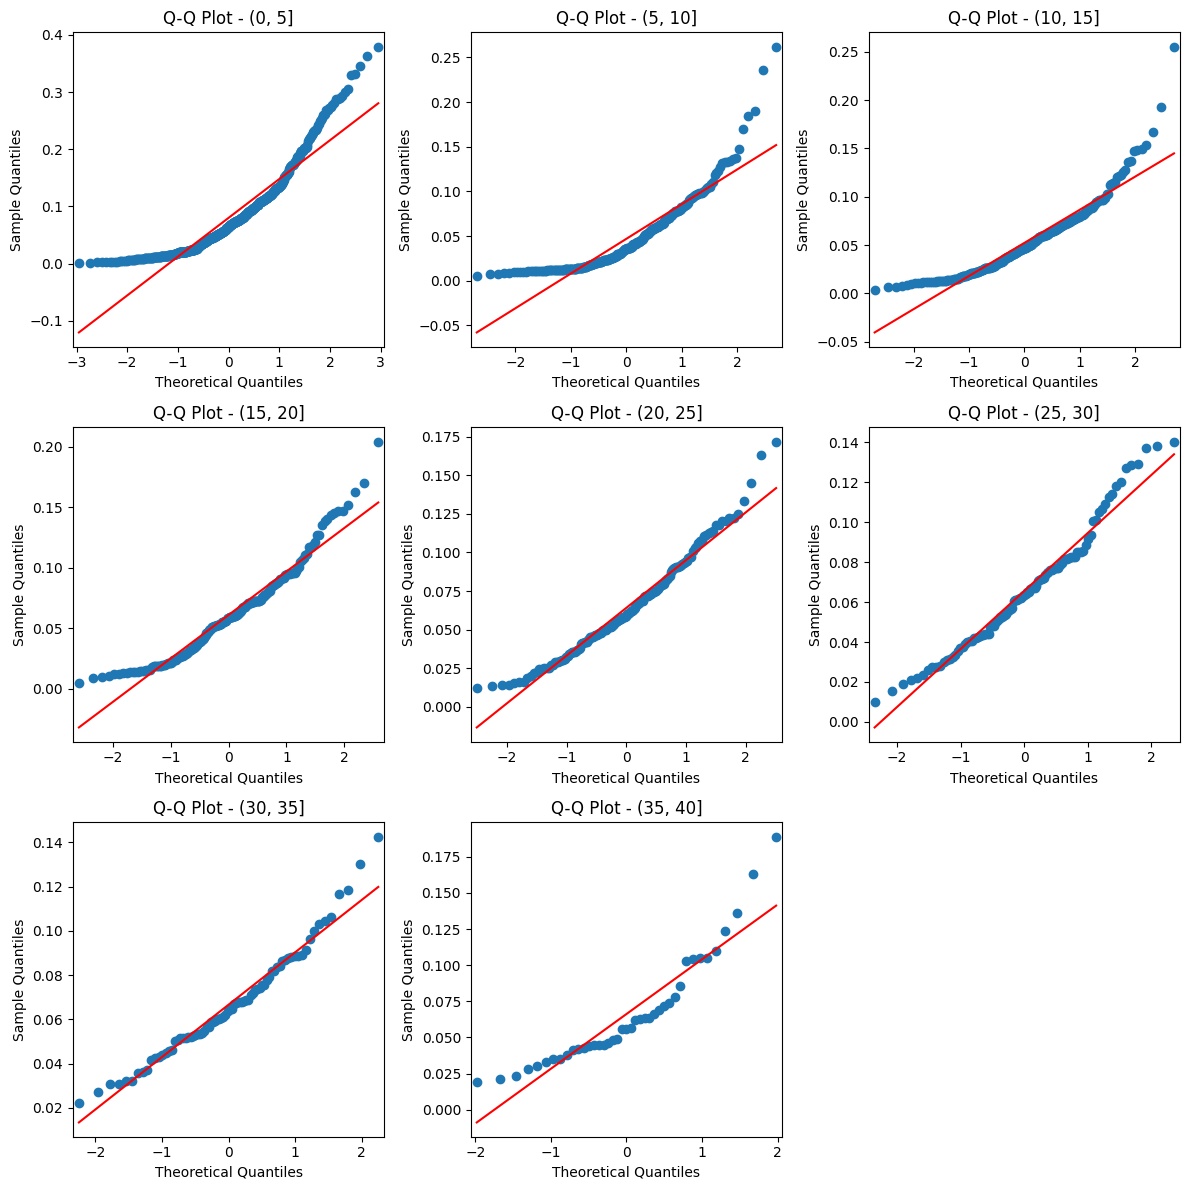

In [26]:
# Determine the number of rows and columns for the grid (3x3 in this case)
rows = 3
cols = 3
num_plots = rows * cols

# Create a new figure and set the size (adjust as needed)
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

# Flatten the axes array into a 1D array to allow for indexing
axes = axes.flatten()

# Iterate through each duration_bin and plot the QQ plot in the corresponding grid cell
for i, (duration_bin, group_data) in enumerate(df_no_outliers.groupby('duration_bin')):
    ax = axes[i]  # Get the current axis in the grid
    sm.qqplot(group_data['engagement'], line='s', ax=ax)
    ax.set_title(f'Q-Q Plot - {duration_bin}')

# Hide any remaining empty plot cells
for i in range(len(df_no_outliers['duration_bin'].unique()), num_plots):
    axes[i].axis('off')

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

# Show the plot
plt.show()

Homogeneity of variances seems to be fulfilled as shown by the Q-Q plots.

The independent ranks condition might be violated for the same reasons the independence condition might be violated. Again, I decided to continue with the test for simplicity.

The random sampling test was violated due to the nature of the data collection process. I automated a script to collect data exactly 2 times a day at the same times. This violates random sampling because not all videos had an equal probability of being selected. In the future, I could try to make the script collect 2 times at random times throughout the day.

Though not all conditions were perfectly fulfilled, here is the test:

**Null Hypothesis**: There is no significant difference in the median engagement among the duration bins.

**Alternative Hypothesis**: At least one of the duration bins differs significantly in median engagement from the others.

In [ ]:
# Perform the Kruskal-Wallis test
groups = [df_no_outliers.loc[df_no_outliers['duration_bin'] == bin, 'engagement'].values for bin in df_no_outliers['duration_bin'].unique()]
statistic, p_value = kruskal(*groups)

# Print the test results
print("Kruskal-Wallis test statistic:", statistic)
print("p-value:", p_value)

Kruskal-Wallis test statistic: 93.78876877167295
p-value: 2.0583546020524735e-17


As shown by the p-value being less than 0.05, we reject the null hypothesis and conclude that at least one of the duration bins differs significantly in median engagement from the others. To determine if the 0-5 minute duration bin has significantly higher engagement than the other bins, we have to do post-hoc test. Dunn's test is a post-hoc test that I'll be using because it is a common test for non-parametric data (determined with a quick Google search). It does pairwise comparisons between the median engagement between groups. It also is used when equal variances is violated (which it is in this case).

In [ ]:
#convert duration_bin to string for later comparisons
df_no_outliers['duration_bin'] = df_no_outliers['duration_bin'].apply(lambda x : str(x))

In [ ]:
# Perform pairwise comparisons using Games-Howell test
pairwise_results = pg.pairwise_gameshowell(data=df_no_outliers, dv='engagement', between='duration_bin')

# Extract the p-values for comparisons involving the (0, 5] bin
comparison_bin = '(0, 5]'  
comparison_results = pairwise_results.loc[pairwise_results['A'] == comparison_bin]

alpha = 0.05

significant_comparisons = comparison_results[comparison_results['pval'] < alpha]

for _, row in significant_comparisons.iterrows():
    duration_bin = row['B']
    p_value = row['pval']
    print(f"Significantly different from {comparison_bin}: {duration_bin} (p-value: {p_value})")

Significantly different from (0, 5]: (5, 10] (p-value: 2.666755705149626e-13)
Significantly different from (0, 5]: (10, 15] (p-value: 0.0)
Significantly different from (0, 5]: (15, 20] (p-value: 2.0468550010588338e-05)
Significantly different from (0, 5]: (20, 25] (p-value: 0.00026724958885271377)
Significantly different from (0, 5]: (25, 30] (p-value: 0.0065581605222697625)
Significantly different from (0, 5]: (30, 35] (p-value: 0.001613318269676145)


In [ ]:
bins

[0, 5, 10, 15, 20, 25, 30, 35, 40]

Looking at the results of the test, we can see that for almost all the bins except 35-40 minutes, the median engagement of 5-10 minute videos is signficantly higher than other durations. Just because there is a signficant difference, does not mean that duration causes engagement in any way. The main takeaway is that Youtubers should stick to shorter form content (5-10 minute videos) to maximize engagement, though this can vary based on video category.

## When is the best time to upload a video?

Note: The published_at contains datetime data of when a video was uploaded in Coordinated Universal Time (UTC).

In [ ]:
time_df = df[['published_at', 'view_count', 'like_count', 'comment_count', 'engagement']].copy()
time_df['published_at'] = pd.to_datetime(time_df['published_at'])

In [ ]:
time_df_hour = time_df.groupby(time_df['published_at'].dt.hour).mean()

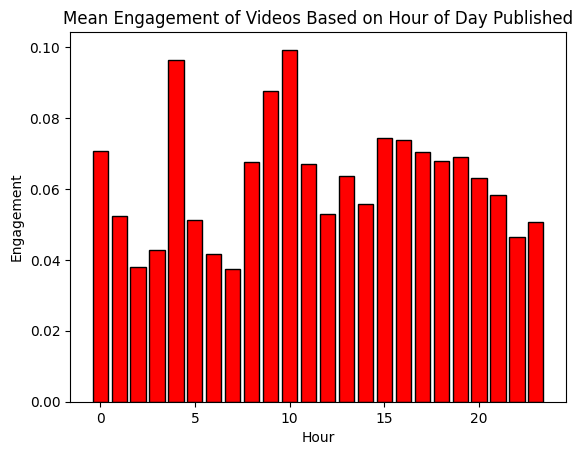

In [ ]:
plt.bar(time_df_hour.index, time_df_hour['engagement'], edgecolor = "black", color = "#FF0000");
plt.xlabel('Hour');
plt.ylabel('Engagement');
plt.title('Mean Engagement of Videos Based on Hour of Day Published');

As shown in the bar graph, hour 4 has the highest mean engagement. Other hours with high engagement are hours 9 and 10. Converted to PDT, 4:00 UTC is 9:00 PDT. Hours to avoid seem to be 1 through 3, and 5 through 9. 

Though no hypothesis testing was conducted, just by looking at the graph, it is reccomended to upload videos at 4, 9, and 10 UTC, while staying away from 1 through 3, and 5 through 9 UTC.

In [ ]:
time_df_day = time_df.groupby(time_df['published_at'].dt.day_name()).mean()
time_df_day = time_df_day.reindex(list(pd.Series(pd.date_range('2023-01-01', periods=7)).dt.day_name()))

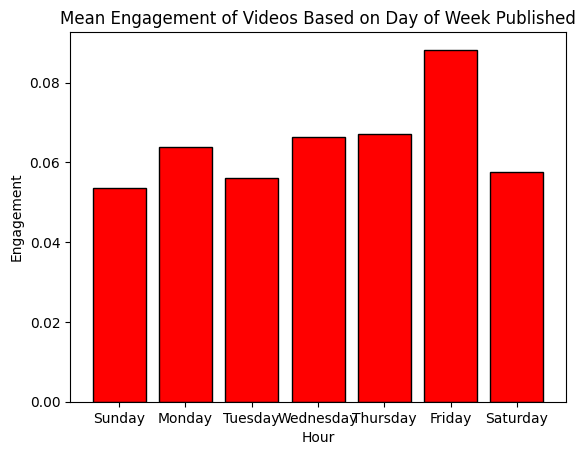

In [ ]:
plt.bar(time_df_day.index, time_df_day['engagement'], edgecolor = "black", color = "#FF0000");
plt.xlabel('Hour');
plt.ylabel('Engagement');
plt.title('Mean Engagement of Videos Based on Day of Week Published');

The mean engagement for videos posted on Friday seems to be highest. Some possible explanations for this are that Fridays are the end of the school and work week for people in the U.S., meaning on Fridays, people will be more available and more likely to engage with Youtube videos.

With this logic, weekends should also have very high engagement, yet this is not reflected in the graph, and there aren't any clear reasons why this happens.

Although no hypothesis testing was conducted, by analyzing the trends in engagement based on day of the week, it is reccommended that creators upload their videos on Fridays.


In [ ]:
time_df_month = time_df.groupby(time_df['published_at'].dt.month).mean()
time_df_month['published_at'] = time_df_month['published_at'].dt.month.map({1: 'January', 2: 'February', 3: 'March', 4: 'April',
                                            5: 'May', 6: 'June', 7: 'July', 8: 'August',
                                            9: 'September', 10: 'October', 11: 'November', 12: 'December'})
time_df_month.reset_index(drop = True)


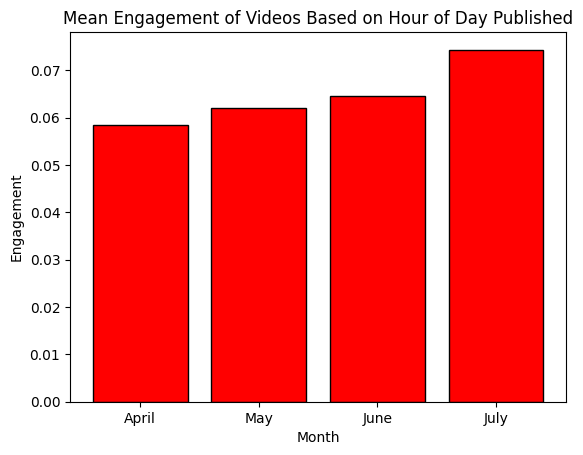

In [ ]:
plt.bar(time_df_month['published_at'], time_df_month['engagement'], edgecolor = "black", color = "#FF0000");
plt.xlabel('Month');
plt.ylabel('Engagement');
plt.title('Mean Engagement of Videos Based on Hour of Day Published');

Because data collection started in April, we don't have much data to look at over the month trends. However, we do seem to see a gradual increase in engagement in videos over time from April to July. While only observing 4 months is inadequate to make a conclusion, a potential reason why this may occur is that May, June, and July are the months many schools start to end. This gives more time for students to pursue other activities during their summer break, one of which could be watching and engaging with Youtube videos.

So while Youtubers probably plan to upload relatively consistently, according to the limited data we have, they can expect to see higher engagement with the videos they post over summer.

## Main Takeaways
1. Generally speaking, Youtubers should stick to short form content (5-10 minute videos) to maxmize their engagement if their type of content can be in short form
2. Upload at 4:00 or 9:00-10:00 UTC to maxmize engagement
3. Videos should be uploaded on Fridays
4. Expect to see an increase in engagement in videos posted over summer